In [72]:
# Julia version code
"""
nonnegative linear regression 
"""
# Discussion from Dec 22
# 1. Currently, our runtime is O(n/sqrt(eps)*(m+n)). The per iteration O(m)
# is unavoidable; however, IF we are NOT required to output the optimizer xtilde_ktotal, 
# then by maintaining 1^T x in each iteration (at a cost of O(1)), we can completely
# avoid O(n) per iteration. 

using LinearAlgebra, BenchmarkTools, Plots, Convex, SCS, NonNegLeastSquares, MLDatasets


In [75]:
function alg_ours(C::Matrix{Float64}, b::Matrix{Float64}, ϵ::Float64)
    
    extra_term_nnls = 0.5*norm(b)^2
    m, n = size(C)
    K = ceil(n / √ϵ)
    previous_A = 1.0/n
    previous_a = previous_A
    a = 1.0/(n*n)
    A = (n+1.0) /(n * n)
    col_norm = norm.(eachcol(C))
    inv_col_norm_square = 1.0 ./(col_norm.^2)
    idx_seq = 1:n
    x = zeros(n)
    p = zeros(n)
    j = rand(idx_seq)
    p[j] += inv_col_norm_square[j]
    x[j] = p[j]
    # x̃ = deepcopy(x)
    previous_y = zeros(m)
    y = x[j] * C[:, j]
    # record Ax
    z = x[j] * C[:, j]
    ȳ = (n+1) * y
    s = zeros(n)
    #func_value = 0
    func_value=zeros(Int(ceil(K/n)))
    
    for k = 2:K
        j = rand(idx_seq)
        p[j] += - n * inv_col_norm_square[j] * a * (sum(C[:,j] .* ȳ) - 1)
        prev_xj = x[j]
        x[j] = min(inv_col_norm_square[j], max(0, p[j]))
        # record Ax
        z[:] += C[:, j] * (x[j] - prev_xj)
        previous_y[:] = y[:]
        y[:] = previous_A/A * y[:] + a/A * z[:] + (n-1) * a/A * (x[j] - prev_xj) * C[:,j]
        s[j] += ((n-1) * a -  previous_A) * (x[j] - prev_xj)
        previous_a, previous_A = a, A
        a = min(n * a/(n-1), sqrt(A)/(2*n))
        ȳ[:] = y[:] + previous_a/a * (y[:] - previous_y[:])
        A += a

        if k % n == 0
            x̃ = x + 1.0/previous_A * s
            C_x̃ = C * x̃
            func_value[Int(k/n)] = 0.5 * sum(C_x̃ .* C_x̃) - sum(x̃)+extra_term_nnls
            #@info "pass: $(k/n), func_value: $func_value"
        end
    end
    return(func_value)
end



alg_ours (generic function with 1 method)

In [87]:
# https://github.com/ahwillia/NonNegLeastSquares.jl
function alg_lawsonhanson(A, b)
    xnnls = nonneg_lsq(A,b;alg=:nnls)  # NNLS

    nnls_optval = 0.5*norm(A*xnnls - b)^2
    
    print("\n nnls package value is ", nnls_optval)
end

alg_lawsonhanson (generic function with 1 method)

In [90]:
# https://github.com/ahwillia/NonNegLeastSquares.jl
function alg_fast_lawsonhanson(A, b)
    xfnnls = nonneg_lsq(A,b;alg=:fnnls) # Fast NNLS

    fnnls_optval = 0.5*norm(A*xfnnls - b)^2
    
    print("\n f-nnls (nnls package) value is ", fnnls_optval)
    
    return(fnnls_optval)
end

alg_fast_lawsonhanson (generic function with 1 method)

In [5]:
# https://github.com/ahwillia/NonNegLeastSquares.jl
function alg_pivot(A, b)
    xpivot = nonneg_lsq(A,b;alg=:pivot) # Pivot Method

    xpivot_optval = 0.5*norm(A*xpivot - b)^2
    
    print("\n pivot alg (nnls package) value is ", xpivot_optval)
end

alg_pivot (generic function with 1 method)

Mnist test

f = Plot{Plots.GRBackend() n=1}

 f-nnls (nnls package) value is 5.923616760000193f = Plot{Plots.GRBackend() n=1}


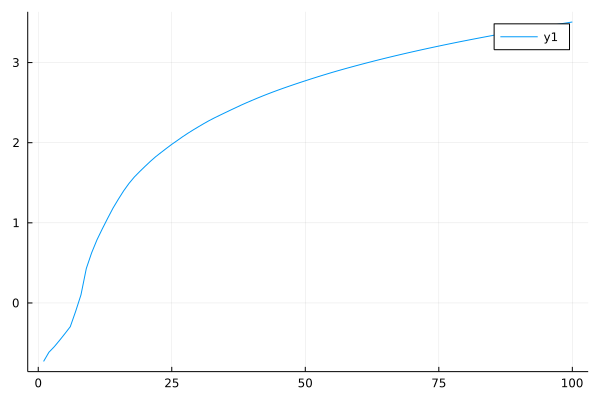

In [96]:
# Main code
function remove_col1(A,b)#Chenghui has an idea to optimize this for speed ("filter")
    s=A'*b # n*1 
    B=A[:,vec(s.>0)] # m*b matrix where b is smaller than n
    s=s[vec(s.>0)] # s is b*1 in dimensions
    return B./s'
end

epsilon = 0.0001 

############# 
n = 1000 # variable dimension 
m = 200 # Number of data points
b=rand(m,1)-repeat([0.3],m,1)
A_init =  max.(0, randn(m, n)) #rand(m,n)#
############

############ Mnist： uncomment 
#train_x, train_y = MNIST.traindata()
#A = Array{Int64}
#b = Array{Int64}
#A_init = reshape(train_x,60000,28*28)
#b = train_y
#test_x,  test_y  = MNIST.testdata()
############


 A = remove_col1(A_init,b)
############ Mnist: uncomment this
# A = Float64.(A)
# b = Float64.(b)
# b1 = vcat(b')
############

(m,n) = size(A) # Redefine the size number n and m to prevent triviality.


#@time begin
our_result = alg_ours(A, b, epsilon)
#our_result = alg_ours(A, b1, epsilon)
#end 

######## Plot
s = alg_fast_lawsonhanson(A, b) # optima value
f = plot(-.5*log.(our_result.-s))
@show f  

# @time begin 
# s=alg_fast_lawsonhanson(A, b)
# end

# @time begin 
# alg_lawsonhanson(A, b)
# end

# @time begin 
# alg_pivot(A, b)
# end


In [59]:
epsilon = 0.005 

@time begin
our_result = alg_ours(A, b1, epsilon)
end 


Array{Float64,1}

Unrealistic test. Dimension is incorrect.

In [24]:
# Main code
function remove_col1(A,b)#Chenghui has an idea to optimize this for speed ("filter")
    s=A'*b # n*1 
    B=A[:,vec(s.>0)] # m*b matrix where b is smaller than n
    s=s[vec(s.>0)] # s is b*1 in dimensions
    return B./s'
end

epsilon = 0.001 
#n = 10000 # variable dimension 
#m = 8000 # Number of data points
#b=rand(m,1)-repeat([0.3],m,1)
#A_init =  max.(0, randn(m, n)) #rand(m,n)#

train_x, train_y = MNIST.traindata()
A = Array{Int64}
b = Array{Int64}

num_features = 60000
A_init = reshape(train_x[:,:,1:num_features],28*28,num_features) # dimension is incorrect specified.
b=ones(28^2)

#num_test_points=5
#A_init = reshape(train_x[1:num_test_points,1:num_test_points,:],num_test_points^2,60000) # dimension is incorrect specified.
#b=ones(num_test_points^2)

A = remove_col1(A_init,b)

(m,n)=size(A) # Redefine the size number n and m to prevent triviality.


@time begin
our_result = alg_ours(A, vcat(b'), epsilon)
end 

# Comment: Memory consuming when n>1000 then it fails.
#@time begin 
#alg_fast_lawsonhanson(A, b)
#end

# Comment: Unstable running time: it takes very long time when n is larger than 1500
#@time begin 
#alg_pivot(A, b)
#end


@time begin 
alg_lawsonhanson(A, b)
end




 our new code value is 164.10074878840322198.309666 seconds (37.95 M allocations: 226.216 GiB, 23.32% gc time)

 nnls package value is 163.70013514929224 18.411831 seconds (161 allocations: 360.754 MiB, 0.24% gc time)



 f-nnls (nnls package) value is 2.3085869569625297f = Plot{Plots.GRBackend() n=1}


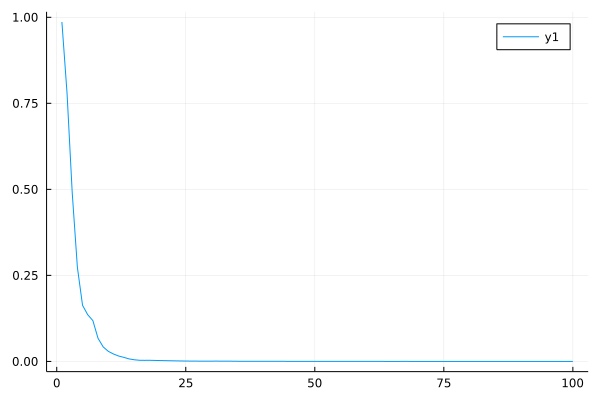

In [92]:

s = alg_fast_lawsonhanson(A, b)

f = plot(our_result.-s)
@show f 